In [91]:
import os
from astropy.io import fits
import cfis

plt.ioff()

In [92]:
# Download spectroscopic data:
# - 3DHST (AEGIS and GOODS-N)
#   http://monoceros.astro.yale.edu/RELEASE_V4.1.5/3dhst.v4.1.5.master.fits.gz
#   (Need to first register at https://3dhst.research.yale.edu/signup.php)
# - DEEP2, DEEP3:
#   deep.ps.uci.edu/deep3/zcat_archive/alldeep.egs.uniq.2012jun13.fits.gz

# Download directory
cat_home = '{}/astro/data/CFIS/spectro_surveys'.format(os.environ['HOME'])

In [93]:
class Survey(object):

    def __init__(self, name, color, dec_min=30, dec_max=90):
        
        self.name = name
        self.color = color
        self.dec_min = dec_min
        self.dec_max = dec_max
        
    @classmethod
    def from_fits(cls, name, color, path, key_ra='ra', key_dec='dec', dec_min=30, dec_max=90):
        """Get coordinates from FITS file
        """
        
        dat = fits.open(path)
        ra = dat[1].data[key_ra]
        dec = dat[1].data[key_dec]
        
        c = cls(name, color, dec_min=dec_min, dec_max=dec_max)
        c.set_coords(ra, dec)
        return c
    
    @classmethod
    def from_array(cls, name, color, ra, dec, dec_min=30, dec_max=90):
        """Get coordinates from arrays
        """
        
        c = cls(name, color, dec_min=dec_min, dec_max=dec_max)
        c.set_coords(np.array(ra), np.array(dec))
        return c

    def set_coords(self, ra, dec):
        """Set coordinates with cuts (UNIONS footprint)
        """  
        
        # Cut area
        idx1 = (self.dec_min < dec)
        idx2 = (dec < self.dec_max)
        idx = idx1 & idx2
        
        n_tot = len(dec)
        n_UNIONS = len(dec[idx])
        print('{}: {} objects in total, {}/{} = {:.1f}% '
              'potentially in UNIONS footprint'
              ''.format(self.name, n_tot, n_UNIONS, n_tot, n_UNIONS/n_tot*100))
        
        self._ra = ra[idx]
        self._dec = dec[idx]
        
        self._min_ra = min(self._ra)
        self._max_ra = max(self._ra)
        self._min_dec = min(self._dec)
        self._max_dec = max(self._dec)

In [94]:
# Spectroscopic survey data
survey = []

# Dummy survey for testing
survey.append(Survey.from_array('Test', 'orange',
                                [1, 1.1], [29.5, 29.6], dec_min=28))       

#survey.append(Survey.from_fits('3DHST-AEGIS', 'green',
#                               '{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
#                               dec_max=60))

# Goods-North has not yet overlap with UNIONS
#survey.append(Survey.from_fits('3DHST-GOODS-N', 'blue',
#                               '{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
#                               dec_min=60))

#survey.append(Survey.from_fits('DEEP2+3', 'magenta',
#                               '{}/alldeep.egs.uniq.2012jun13.fits'.format(cat_home),
#                               key_ra='RA', key_dec='dec'))

Test: 2 objects in total, 2/2 = 100.0% potentially in UNIONS footprint


In [95]:
# CFIS data

# Variables
unit = 'deg'
image_type = 'tile'
bands = ['r', 'u']
colors = ['r', 'b']
d = 0.5
sp_home = '{}/astro/repositories/github/shapepipe'.format(os.environ['HOME'])
tiles_dir = '{}/aux/CFIS/tiles_202011'.format(sp_home)
tiles_ID = {
    'r' : '{}/tiles_r.txt'.format(tiles_dir),
    'u' : '{}/tiles_u.txt'.format(tiles_dir)
}

# Get list of all images
images = {}
for band in bands:
    images[band] = cfis.get_image_list(tiles_ID[band], band, image_type, input_format='ID_only', verbose=True)

12621 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_r.txt'
27291 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202011/tiles_u.txt'


In [96]:
import imp
imp.reload(cfis)

angles = {}
images_overlap = {}
for s in survey:

    print(s.name)

    # Create area string
    area_str = '{0:.2f}{4}_{1:.2f}{4}_{2:.2f}{4}_{3:.2f}{4}'\
               ''.format(s._min_ra - d,
                         s._min_dec - d,
                         s._max_ra + d,
                         s._max_dec + d,
                         unit)
    #area_str = '-0deg_29.5deg_0.1deg_29.6deg'
    #print(area_str)
    
    # Get area coordinates from string
    angles[s] = cfis.get_Angle_arr(area_str, num=4)
 
    # Get images in selected area
    images_overlap[s] = {}
    for band in bands:
        images_overlap[s][band] = cfis.find_images_in_area(images[band], angles[s], band, image_type)
        print(' {} {}-band images in overlap area found'
              ''.format(len(images_overlap[s][band]), band))

Test
 6 r-band images in overlap area found
 6 u-band images in overlap area found


Plotting Test...


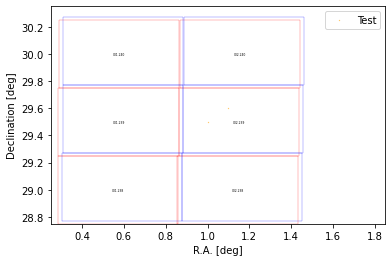

In [97]:
import imp
imp.reload(cfis)

for s in survey:
    print('Plotting {}...'.format(s.name))
 
    fig, (ax) = plt.subplots()
    #plt.tight_layout()

    # Plot spectroscopic objects
    ax.plot(s._ra, s._dec, '.', color=s.color, markersize=0.5, label=s.name)

     # Plot images
    show_numbers = True
    dxy = 0
    for band, color in zip(bands, colors):
        rac, dec, rad = cfis.plot_area(images_overlap[s][band], angles[s], image_type, None, False,
                                       col=color, show_circle=False, show_numbers=show_numbers,
                                       ax=ax, dxy=dxy, save=False)
        show_numbers = False
        dxy = dxy + 0.02

    plt.xlabel('R.A. [{}]'.format(unit))
    plt.ylabel('Declination [{}]'.format(unit))
    plt.legend(loc='best')
    plt.savefig('{}.png'.format(s.name))
    plt.show()

In [16]:
for band in bands:
    for img in images_overlap[band]:
        img.print()

CFIS.251.288.r.fits
CFIS.252.288.r.fits
CFIS.253.288.r.fits
CFIS.254.287.r.fits
CFIS.254.288.r.fits
CFIS.255.287.r.fits
CFIS.256.287.r.fits
CFIS.257.286.r.fits
CFIS.257.287.r.fits
CFIS.258.286.r.fits
CFIS.259.286.r.fits
CFIS.260.285.r.fits
CFIS.260.286.r.fits
CFIS.261.285.r.fits
CFIS.262.285.r.fits
CFIS.263.284.r.fits
CFIS.263.285.r.fits
CFIS.264.284.r.fits
CFIS.265.284.r.fits
CFIS.266.283.r.fits
CFIS.266.284.r.fits
CFIS.267.283.r.fits
CFIS.268.283.r.fits
CFIS.269.283.r.fits
